# Seattle Home Sales Analysis
#### By Eldrich Ver Doyogan and Alexis Kedo

   ![title](seattle-skyline-illustration-washington-95598619.jpeg)

## Overview

Opendoor Technologies Inc is an online company for transacting in residential estate. Headquarted in San Fransisco, the company allows for instant cash offers on homes through an online process and makes repairs on properties purchased in order to reslist them for sale. This data analysis aims to create a foundational understanding as the company continues to expand its geographical reach. The data used in this analysis is the King County House Sales dataset from Seattle, Washington. The method by which we analyzed the data is multiple linear regression. We aimed to see which factors impact sale prices most, so that Opendoor may shift their focus to key criteria. 

## Business Understanding

Housing demand has risen in 2021 despite the global battle against the pandemic. In order to meet this demand, Opendoor wants to acertain which features of properties affect sales prices most. OpenDoor has gained a lot of market traction lately, as it enables sellers to close remotely (important during the Covid-19 pandemic). However, this means that quantifiable features are even more important, as in-person appraisals and walk-throughs are not conducted as frequently. With our model, we aimed to give OpenDoor a few factors that we consider to be significant predictors of sales price. Properties which possess qualities that bring prices up should be top priority for the company -- qualities which this analysis aims to uncover.

## Data Understanding

The data is the King County House Sales dataset from Seattle, Washington that catalogs homes sold between May 2014 and May 2015. It initially contains 20 columns. These columns are: 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', and 'sqft_lot15'. The descriptions for the columns can be found in the folder named data, in the file named column_names.md within this notebook. There are 21597 entries prior to data cleaning. 

## Importing Data and Initial Look

As always, we began with importing all the necessary packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.api as sm
import pylab
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
import functions as fn

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)


In [3]:
cd data

/Users/alexiskedo/Documents/Data Science/Projects/Phase 2 Project/Seattle-Home-Sales-Dataset-Analysis/data


In [4]:
data_f = pd.read_csv('kc_house_data.csv')
data = pd.read_csv('kc_house_data.csv')

More in-depth data exploration can be found in our individual notebooks. However, we can examine the mean and median in each column for a high-level overview: 

In [5]:
df_mean_median = pd.DataFrame(data = (data.median(), data.mean()), index = ['median', 'mean'])
# Creating a df 'data_mean_median' which compares the median and mean of each column 
# in order to glimpse at skewness of each feature
df_mean_median

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
median,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"


Sqft_lot has a significant right skew (positive skew), with the mean double that of the median. This might be due to the fact that Seattle has a lot of sprawl (with a relatively low proportion of small condos/apartments in the city center). Price has a slightly less significant postive skew, with the mean being around 120% that of the median.

### Targets and Predictors

The target we are trying to predict is the price. It's worth exploring the distribution of home prices, as well as exploring if there are any trends for this future from year to year. 

Eldrich used a histogram to visualize the price distribution: 

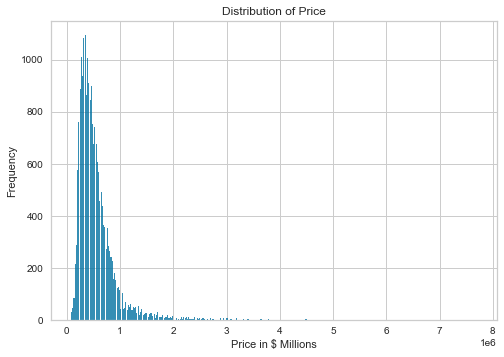

In [6]:
plt.hist(x = data_f.price, bins = 'auto', alpha = 0.80, rwidth= .85)
plt.xlabel('Price in $ Millions')
plt.ylabel('Frequency')
plt.title('Distribution of Price');

We can also aggregate home sales into different pricing bands and visualize the number of homes sold in each price band in 2014 and 2015 (Code for this visualization is in the "Kedo" branch of this repository).

 ![title](images/price_barchart_1.png)

 ![title](images/price_barchart_2.png)

## Data Preparation and Cleaning

In this step, we discarded outliers and data entries which were catalogued with clear mistakes. After some thought, Eldrich and I decided to drop only one transaction that was clearly a data entry error (a 33-bedroom house that sold for $640,000).

Since duplicates were a very small percentage of the dataset, we decided to leave duplicates in. Eldrich also removed nulls in the Waterfront column as he utilized this feature in his initial modeling. 

We also split up the data and divvied up the features we would each focus on. In the location-home feature analysis, Alexis took into account location data, and specifically zipcode data, as it is generally known that location is one of the most important determinants of real estate prices. We call this the "Location-Home Features" analysis.

In the "Ordinal-Home Feature" analysis, Eldrich sought to maximize the predictive power of the home features themselves, as well as other non-continuous features present in the data (such as a home's location by the waterfront). 

In order to maximize the usefulness of this model, we both decided include the categorical home features that most people take into account when buying a home -- bedrooms, bathrooms, square footage, and number of floors, for example.

**Ordinal-Encoding Analysis**: As an example, below is the cleaning process for the Ordinal-Home Feature Analysis. Please refer to the "Location-Home Feature" and "Ordinal-Encoding" notebooks for more details on the feature selection rationale. 

In [13]:
mask = data_f.loc[data['bedrooms']>20].index
data_f.drop(mask, axis = 0, inplace=True)

In [7]:
to_drop = ['id', 'view', 'sqft_above', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement', 'date', 'yr_built' ]

In [8]:
data_f.drop(to_drop, axis = 1, inplace = True)

In [9]:
data_f.waterfront.fillna(0.0, inplace = True)
data_f.yr_renovated.fillna(value = 0, inplace = True)
data_f.loc[(data_f.yr_renovated > 0), 'yr_renovated'] = 1
bedroom_outlier = data_f.loc[data_f['bedrooms'] == 33].index
data_f.drop(bedroom_outlier, axis = 0,  inplace = True)
price_outlier = data_f.loc[data_f['price'] == data_f.price.max()].index
data_f.drop(price_outlier, axis = 0,  inplace = True)
sqft_lot_outlier = data_f.loc[data_f['sqft_lot'] == data_f.sqft_lot.max()].index
data_f.drop(sqft_lot_outlier, axis = 0,  inplace = True)
bathrooms_outlier = data_f.loc[data_f['bathrooms'] == data_f.bathrooms.max()].index
data_f.drop(bathrooms_outlier, axis = 0,  inplace = True)

In [10]:
data_f = data_f.loc[data_f.price <= (data_f.price.mean() + (2 * data_f.price.std()))]

In [12]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20740 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         20740 non-null  float64
 1   bedrooms      20740 non-null  int64  
 2   bathrooms     20740 non-null  float64
 3   sqft_living   20740 non-null  int64  
 4   sqft_lot      20740 non-null  int64  
 5   floors        20740 non-null  float64
 6   waterfront    20740 non-null  float64
 7   condition     20740 non-null  int64  
 8   grade         20740 non-null  int64  
 9   yr_renovated  20740 non-null  float64
 10  zipcode       20740 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 1.9 MB


### Checking Assumptions

This analysis uses Multiple Regression in order to predict property sales prices. Using this model requires checking the assumptions of regression. These assumptions are: 
- Linear relationship (model can draw a line of best fit for predicting price)
- Multivariate normality (predictors are normally distributed)
- No or little multicollinearity (predictors do not exhibit a linear relationship with one another)
- Homoscedasticity (residuals have a constant variance) 

Assumptions were checked prior to running any regressions and in between model iterations. Below are some examples of how the team checked for regression assumptions and corrected as needed. More rationale and specific code can be found in our indvidual notebooks.

**Location-Home Feature Analysis**: For this analysis, both continuous and categorical features were chosen. Iterations relied primarily on coefficient heatmaps and tables to check for multicollinearity and residual scatterplots to check for normality, linearity, and homoscedasticity. Below is a residuals scatterplot that displayed non-normality as well as heterskedascicity: 
![name](images/heteroskedastic_residuals.png)

An example of how we restored some normality and homscedasticity through a log-transformation of continuous variables is shown below: 

![name](images/homoskedastic_residuals.png)

More details on how we checked and accounted for regression assumptions can be found in the "Location-Home Features" and "Ordinal-Encoding"notebooks.

## Modeling Process
### Initial Findings

After the data was commonly cleaned and features were decided on, we each undertook our own explorations of the data. Eldrich created a series of boxplots to depict the relationships between the dependent variable and independent variables, while Alexis sought to create a visualization that shows the relationship between one independent variable (a home's location, shown through zip code) and the dependent variable (price). 

#### Ordinal Encoding Analysis (Eldrich)

Below are code snippets and the resulting visualizations from the Ordinal Encoding Analysis.

In [15]:
def boxit(DataFrame, independent, dependent):
    """ Returns boxplot of chosen independent column and dependent column.
        
        Parameters:
        DataFrame: A Pandas DataFrame
        Independent: Column or feature from dataframe to be chosen as the predictor variable
        Dependent: Column to be predicted
        """
    ax = sns.boxplot(data = DataFrame, x = independent, y = dependent)
    return

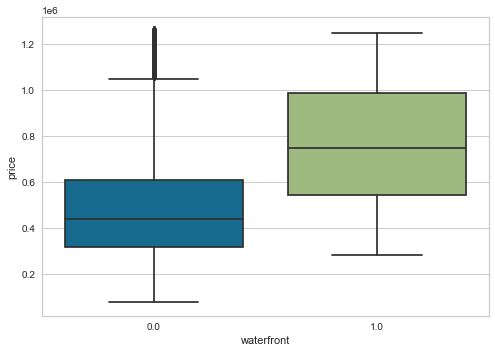

In [16]:
boxit(data_f, 'waterfront', 'price')

As shown here, the interquartile range of waterfront properties (marked as 1.0 on boxplot) is larger thus the range of price for the middle half of waterfront properties is also larger. 

The upper quartile of waterfront properties is more expensive while its lower quartile is 
around the same price as the upper quartile of non-waterfront properties. 

Both maximum and minimum values (denoted by the boxplot's whiskers) are higher respectively 
for waterfront properties.

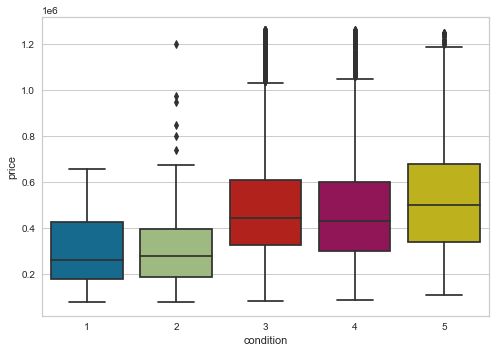

In [17]:
boxit(data_f, 'condition', 'price')

Properties' condition don't appear to show high correlation with price, with each condition -posting relatively similar price ranges. It does appear that outliers peak at condition-3.

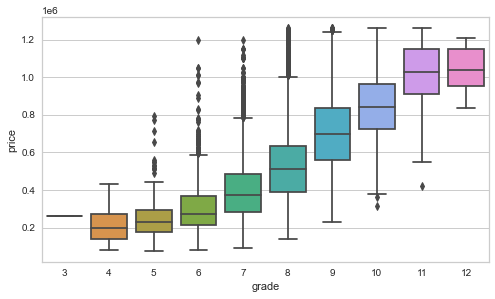

In [21]:
boxit(data_f, 'grade', 'price')

There is a rising pattern in prices as the grade of properties go up, this can certainly 
be an indicator of a linear relationship between property grade and price. 

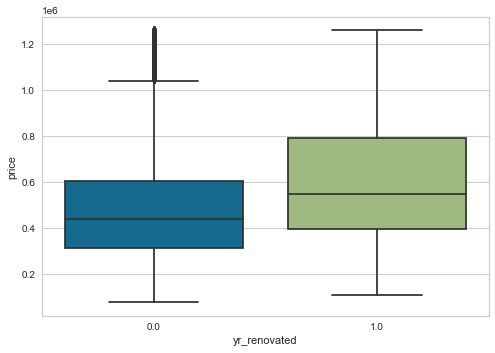

In [18]:
boxit(data_f, 'yr_renovated', 'price')

The price range difference between either renovated or not does not seem to affect the price as much.

#### Location-Home Features Analysis (Alexis)

To engineer a location feature, I chose to use the median price for each individual zip code. Zip code is a categorical feature, which is oftentimes dealt with through one-hot encoding. However, given the many unique zip codes present in the dataset (70), I was concerned that adding 70 additional variables to my dataset would increase the dimensionality to a point that decreases the reliability of the model.

Therefore, using the median price for each zip code seemed like an appropriate proxy and could be a reasonably good predictor of future home prices for that area.

My strategy will be to replace all values in zipcode column with median sale price. I will group all zipcodes together with median average sale price, and replace any zipcode value with its median average sales price. This will give my model some context about the potential values of each home based on its location within the Seattle area. 

This is an imperfect strategy - another method would be to map zip codes and aggregate based on neighborhood, as people often refer to neighborhood, rather than zip codes, when discussing real estate. However, I have limited knowledge of the Seattle area and doing this sort of mapping would take some time - but it would be interesting to see how a neighborhood-based model compares to a zip-code based model. For our business scenario, let's assume that OpenDoor collects both zip code and neighborhood data on potential purposes and that either would be valuable to them.

Before running a regression, it might be useful to visualize the median price per zip code. I did this by sourcing some location data from the King County GIS Database (King County contains the Seattle metro area). Then, I overlayed this geojson file on a folium map of Seattle, then used my referential dataframe above to tag each geographic zip code with its zipcode label and median sales price. The code for this process can be found in the separate "Location-Home Feature" notebook.

![](images/map.png)

[Here is a link](https://nbviewer.jupyter.org/github/alexiskedo/Seattle-Home-Sales-Dataset-Analysis/blob/Kedo/data/zipcode_price_map.html) to view the full map. 

### Train-Test Split and Initial Modeling
The final step before the actual modeling was dividing data into training and testing splits. Below is a code sample from the Ordinal Encoding Analysis that displays our process. We chose a ratio of 80/20 (training/testing) as this is an accepted industry standard. 

#### Ordinal Encoding Analysis (Eldrich)

In [19]:
X_ = data_f.drop('price', axis = 1)
y_ = data_f.price
X_Train, X_Test, y_Train, y_Test = train_test_split(X_, y_, test_size = 0.2, random_state = 42)

In [20]:
#Creating a function to turn datatypes as category
def cat(df, cat_data):
    """Turns desired features of dataframe into categorical data.
    
        Parameters:
        df(DataFrame): Pandas DataFrame from which to pull columns
        cat_data(list): list object that specifies column names"""
    for feature in list(df.columns):
        if feature in cat_data:
            df[feature] = df[feature].astype('category')
    return

In [21]:
categories = ['condition', 'grade', 'waterfront', 'yr_renovated']
# Listing which columns I would like to run through my cat function

cat(X_Train, categories)
cat(X_Test, categories)
# Running train and test independent variables through cat

dummy_train = pd.get_dummies(X_Train[categories], drop_first = True )
dummy_test =  pd.get_dummies(X_Test[categories], drop_first = False )
dummy_test.drop(['condition_1', 'waterfront_0.0', 'yr_renovated_0.0'],
                   axis = 1, inplace = True)

<ipython-input-20-d16a2ec9fcf2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype('category')


In [22]:
X_Train = X_Train.drop(['yr_renovated', 'waterfront', 'condition', 'grade', 'zipcode'], axis = 1)
X_Test = X_Test.drop(['yr_renovated', 'waterfront', 'condition', 'grade', 'zipcode'], axis = 1)

### Refining Results

Information about each first substandard model (FSM) can be found in individual notebooks for each analysis. Below is a description of diffrent strategies each partner employed to iterate on their FSM. 

#### Ordinal- Encoding Analysis (Eldrich)

In order to address the collinearity between sqft_living and bedroom, I decided to combine them to show the amount of square footage of the living area in comparison to the bedroom count, while also dropping the bedroom column. 

In [23]:
# For later iteration
Sqft_Bed_Train = (X_Train.sqft_living / X_Train.bedrooms)
Sqft_Bed_Test = (X_Test.sqft_living / X_Test.bedrooms)

In [24]:
# Combining categorical data with non-categorical data 
# Using logged transformed values for non_categorical data 
variables = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']
for feature in variables:
    X_Train[feature] = X_Train[feature].map(lambda x: np.log(x))
for feature in variables:
    X_Test[feature] = X_Test[feature].map(lambda x: np.log(x))

In [25]:
X_Train = X_Train.join(dummy_train)

In [26]:
X_Test = X_Test.join(dummy_test)

In [27]:
SS = StandardScaler()
X_Train_Scaled = SS.fit_transform(X_Train)
X_Test_Scaled = SS.transform(X_Test)

In [28]:
regression = LinearRegression()
regression.fit(X_Train_Scaled, y_Train)

LinearRegression()

In [29]:
train_y_m5 = regression.predict(X_Train_Scaled)
test_y_m5 = regression.predict(X_Test_Scaled)

In [30]:
print('Coefficients: ', X_Train.columns, regression.coef_)
print('Intercept: ', regression.intercept_)
print('------')
print('R2 Train: ', r2_score(y_Train, train_y_m5))
print('MAE Train: ', mean_absolute_error(y_Train, train_y_m5))
print('--------')
print('R2 Test: ', r2_score(y_Test, test_y_m5))
print('MAE Test: ', mean_absolute_error(y_Test, test_y_m5))

Coefficients:  Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition_2', 'condition_3', 'condition_4', 'condition_5', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10',
       'grade_11', 'grade_12', 'waterfront_1.0', 'yr_renovated_1.0'],
      dtype='object') [-15448.80364305 -18105.9178347  100280.87618276 -25739.94660245
  -6368.89888623   2178.17566266  10634.68903391  30401.11427399
  35542.24109568    766.86608881  -3839.73501146  -6318.59921416
  13266.99205161  53389.9088463   81820.54370506  75118.35133498
  49227.09444407   9458.20613458  15287.41959487  20065.39954788]
Intercept:  486347.5015067501
------
R2 Train:  0.5270359456577862
MAE Train:  119905.40709878887
--------
R2 Test:  0.5225543614282906
MAE Test:  118652.80967262997


The coefficients of the model include negative coefficients. This might be explained by the various independent variables interacting with each other that could affect the model's prediction on the dependent variable. I will address this in later models.

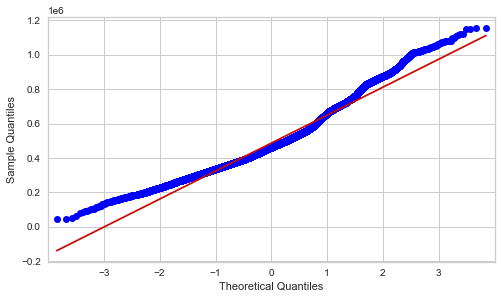

In [43]:
sm.qqplot(train_y_m5, line = 's')
pylab.show()

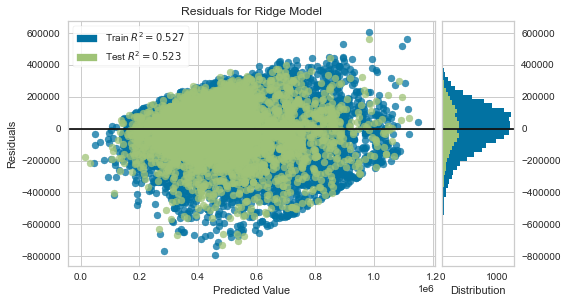

In [44]:
model5 = Ridge()
visualizer = ResidualsPlot(model5)

visualizer.fit(X_Train, y_Train)  
visualizer.score(X_Test, y_Test) 
visualizer.show();

#### Location-Home Feature Analysis (Alexis) 

Below is a code sample for the first iteration after my initial regression. I created a new dataframe that aggregated median price by zip code and then joined it to my initial training and testing dataframes. For more information, pleae see the location-home feature analysis notebook.

In the interest of not inserting many lines of code into this shared notebook, I have included a screenshot of my regression results, as well as included some written analysis. Please see the Location-Home Feature Analysis notebook for the complete code. 

![](images/refining_results.png)

Just feeding our model some meaningful location data had a big impact on our coefficient of determination. Our model is now accounting for between 72-73% of the variance in our data. Though we underfit our first model, our training now higher than testing, which is an indication of slight overfitting. Our Mean Absolute Error went down slightly, and is now a little less than half of one standard deivation, hovering around $112,000. Obviously, this is still a big difference for the home seller who may be paying off a loan when they sell to OpenDoor. It certainly would make me gulp. We want to try and lower this error as much as possible.

### Final Model Results 
After we iterated each model several times, we settled on a "final" model. Below are coding samples and explanation of the final results from each analysis.

#### Ordinal-Encoding Analysis (Eldrich)

In [32]:
X_Train['Sqft_Bed'] = Sqft_Bed_Train
X_Test['Sqft_Bed'] = Sqft_Bed_Test

In [33]:
X_Train['Sqft_Bed'] = X_Train['Sqft_Bed'].map(lambda x: np.log(x))

In [34]:
X_Test['Sqft_Bed'] = X_Test['Sqft_Bed'].map(lambda x: np.log(x))

In [35]:
# This model drops the dummy variables in condition for we saw that they did not affect price in the boxplots above
conditions = ['condition_2', 'condition_3', 'condition_4', 'condition_5']
X_Train.drop(conditions, axis = 1, inplace = True)

In [36]:
X_Test.drop(conditions, axis = 1, inplace = True)

In [37]:
# This model droops the columns below to address the problem of discussed above. 
# The negative coefficients should disappear by removing these columns.

to_be_drop = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'grade_4', 'grade_5', 'grade_6', 'grade_7']

In [38]:
X_Train.drop(to_be_drop, axis = 1, inplace = True)
X_Test.drop(to_be_drop, axis = 1, inplace = True)

In [39]:
SS = StandardScaler()
X_Train_Scaled = SS.fit_transform(X_Train)
X_Test_Scaled = SS.transform(X_Test)

In [40]:
regression = LinearRegression()
regression.fit(X_Train_Scaled, y_Train)

LinearRegression()

In [41]:
regression = LinearRegression()
regression.fit(X_Train_Scaled, y_Train)

LinearRegression()

In [42]:
train_y_m8 = regression.predict(X_Train_Scaled)
test_y_m8 = regression.predict(X_Test_Scaled)

In [43]:
y_Train.describe()

count      16,592.00
mean      486,347.50
std       223,796.16
min        78,000.00
25%       316,000.00
50%       440,000.00
75%       611,000.00
max     1,260,000.00
Name: price, dtype: float64

In [44]:
print('Coefficients: ', list(zip(X_Train.columns, regression.coef_)))
print('Intercept: ', regression.intercept_)
print('------')
print('R2 Train: ', r2_score(y_Train, train_y_m8))
print('MAE Train: ', mean_absolute_error(y_Train, train_y_m8))
print('--------')
print('R2 Test: ', r2_score(y_Test, test_y_m8))
print('MAE Test: ', mean_absolute_error(y_Test, test_y_m8))

Coefficients:  [('sqft_living', 66598.15220721008), ('grade_8', 38170.81363473664), ('grade_9', 65540.2365379287), ('grade_10', 62113.74173073616), ('grade_11', 41769.45318483209), ('grade_12', 8400.784971161), ('waterfront_1.0', 14229.748409030437), ('yr_renovated_1.0', 17858.112747170882), ('Sqft_Bed', 15458.911889925606)]
Intercept:  486347.5015067502
------
R2 Train:  0.4924816834305994
MAE Train:  124867.0891134175
--------
R2 Test:  0.49426375885604323
MAE Test:  122451.41472887575


The mean absolute error is higher than previous models, and the R2 is lower, however, the coefficients now are able to predict the price without showing the relationship to be inverse. I suspect the categorical variables lowering the R2.

- 1 standard deviation above the mean for sqft_living raises the price by ~6659 dollars
- Grades 9 and 10 seem to drive up the prices siginificantly more than grades 11 and 12. Buyers may want a lower 'grade' because higher grading may indicate a more specific look/style which may turn off potential buyers.
- Waterfront houses also raise the value of the property, albeit not significantly
- Houses which are renovated raise the value of the property by ~ 17858 dollars at one standard deviation above the mean.
- Similarly, Sqft_Bed raises the price at ~ 15458 dollars at 1 standard deviation from the mean

#### Location-Home Feature Analysis (Alexis)

Again, please see the Location-Home Feature Analysis for the complete code. For my final model, I attempted to mitigate some potential multicollinearity in my two square footage columns through creating and log-transforming a new square-footage ratio column. 

Below are the results of my final regression with the errors displayed in dollar amounts:

![](images/final_results.png)

Combining the square footage and square footage of nearest 15 neighbors into one ratio feature apparently does not result in a model with less error. The coefficient of determination went down slightly, while both the root mean squared error and the mean absolute error went up slightly, by about  $ 5k for the mean absolute error and about $ 8k for the root mean squared error, back up to hover around almost $100,000, which would carry significant consequences both for our stakeholder's capital and the amount that sellers receive.

However, I think accounting for this potential multicollinearity is ultimately a good thing for the integrity of our model; ultimately, we want to make sure all our independent variables are truly independent. Furthermore, combining these two columns did not ding our r-squared by *that* much. 

Therefore, I think this is overall a fairly reliable model and a good stopping point for right now. Given more time, I could address the other multicollinear relationships flagged above, and try other methods to reduce that error - for example, changing the square footage ratio to something else, or combining with Eldrich's engineered features and testing further. 

## Model Validation & Evaluation
Below is a summary of how each partner validated their final model, as well as a summary of any evaluation considerations. 

#### Ordinal-Encoding Analysis (Eldrich)

In [47]:
pd.DataFrame(X_Train).corr(method='pearson')

,sqft_living,grade_8,grade_9,grade_10,grade_11,grade_12,waterfront_1.0,yr_renovated_1.0,Sqft_Bed
sqft_living,1.00,0.19,0.37,0.30,0.19,0.03,0.00,0.03,0.72
grade_8,0.19,1.00,-0.23,-0.13,-0.06,-0.01,0.00,0.02,0.16
grade_9,0.37,-0.23,1.00,-0.08,-0.04,-0.01,0.00,0.00,0.32
grade_10,0.30,-0.13,-0.08,1.00,-0.02,-0.00,-0.00,-0.02,0.29
grade_11,0.19,-0.06,-0.04,-0.02,1.00,-0.00,-0.01,-0.01,0.17
grade_12,0.03,-0.01,-0.01,-0.00,-0.00,1.00,-0.00,-0.00,0.03
waterfront_1.0,0.00,0.00,0.00,-0.00,-0.01,-0.00,1.00,0.08,0.04
yr_renovated_1.0,0.03,0.02,0.00,-0.02,-0.01,-0.00,0.08,1.00,0.04
Sqft_Bed,0.72,0.16,0.32,0.29,0.17,0.03,0.04,0.04,1.00


No strong correlation between independent variables with the exception of Sqft_Bed and sqft_living. This is almost certainly due to the former being a derivitive of the latter. 

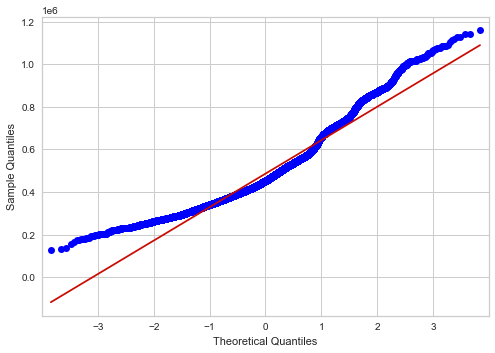

In [48]:
sm.qqplot(train_y_m8, line = 's')
pylab.show()

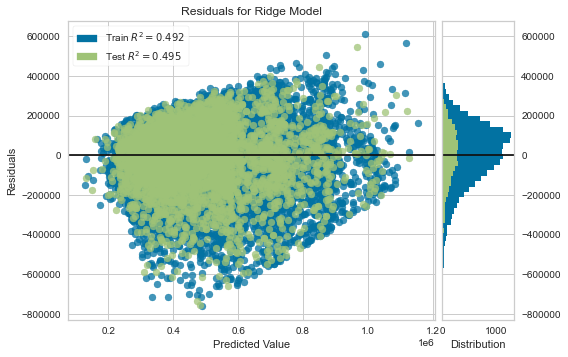

In [49]:
model8 = Ridge()
visualizer = ResidualsPlot(model8)

visualizer.fit(X_Train, y_Train)  
visualizer.score(X_Test, y_Test) 
visualizer.show();

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


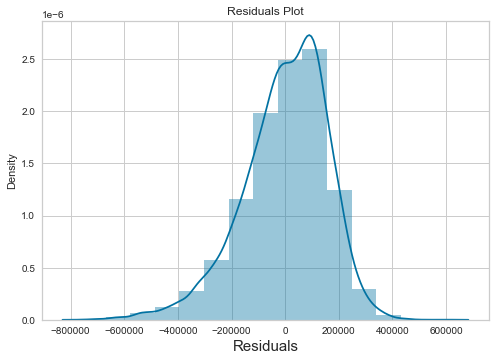

In [50]:
sns.distplot(train_y_m8 - y_Train, bins = 15)
plt.xlabel('Residuals', fontsize = 15)    
plt.title('Residuals Plot')
plt.show();

The model appeared to have suffered from the inclusion of categorical data, with only a little under 50% of the data variance being accounted for. This may have been because certain variables were sparse (waterfront and yr_renovated). The Mean Absolute Error is about 25% larger than Alexis' MAE value.  

In [51]:
coef = pd.DataFrame(zip(X_Train.columns, regression.coef_))
coef

,0,1
0,sqft_living,"66,598.15"
1,grade_8,"38,170.81"
2,grade_9,"65,540.24"
3,grade_10,"62,113.74"
4,grade_11,"41,769.45"
5,grade_12,"8,400.78"
6,waterfront_1.0,"14,229.75"
7,yr_renovated_1.0,"17,858.11"
8,Sqft_Bed,"15,458.91"


The coefficients show that sqft_living and grades 9 and 10 impacted the sales price the most. Furthermore, waterfront, renovated, and footage living per number of bedroom seem to affect the price similarly. Initially, it appeared as though waterfront was going to be a strong predictor of sales prices. However, the model does not support this claim. This may be due to the sparseness of waterfront properties. Afterall, waterfront properties are limited to lining the coast, or in this case, the puget sound watershed. The number of properties outside of the interquartile range of non-waterfront houses may drown out the impact waterfront features have on sales prices. Similarly, yr_renovated (modeled as either having gone under renovation or not renovated regardless of date) is sparsely populated. The same explanation can be referenced for the low impact the feature has in determining the price of properties. Grades 8-11 appear to have a significant impact on price. The original scale of the grading system is between 1-12. This suggests that 'excellent' properties drive sales prices up. Lastly, sqft_living naturally is the main indicator of sales price. Bigger houses fetch for higher in most housing markets. 

In [52]:
print('Coefficients: ', list(zip(X_Train.columns, regression.coef_)))
print('Intercept: ', regression.intercept_)
print('------')
print('R2 Train: ', r2_score(y_Train, train_y_m8))
print('MAE Train: ', mean_absolute_error(y_Train, train_y_m8))
print('--------')
print('R2 Test: ', r2_score(y_Test, test_y_m8))
print('MAE Test: ', mean_absolute_error(y_Test, test_y_m8))

Coefficients:  [('sqft_living', 66598.15220721008), ('grade_8', 38170.81363473664), ('grade_9', 65540.2365379287), ('grade_10', 62113.74173073616), ('grade_11', 41769.45318483209), ('grade_12', 8400.784971161), ('waterfront_1.0', 14229.748409030437), ('yr_renovated_1.0', 17858.112747170882), ('Sqft_Bed', 15458.911889925606)]
Intercept:  486347.5015067502
------
R2 Train:  0.4924816834305994
MAE Train:  124867.0891134175
--------
R2 Test:  0.49426375885604323
MAE Test:  122451.41472887575


The R2 score for both the train and test sets moderately predict the sales prices at around 49%. This may due to the inclusion of categorical data in the model. The MAE is acceptable for predicting house prices for properties tend to fluctuate in price as homeowners and buyers negotiate price. The price may also fluctuate due to market demands and changing neighborhood characteristics. 

The model explaining around 50% of the variance in the data can be used as an initial filter for Opendoor. Future models can be used to continue zeroing in properties which include features which can explain sales prices to a higher degree than this model. 

#### Location-Home Features Analysis (Alexis) 

**Validation**: Due to the multiple dataframes that need to be imported in order to display the validation visualization successfully, I will not include the entire coding process here. However, after my third iteration (which involved engineering a new, ratioed square footage feature), I validated my model through a histogram of my model residuals. 

Though my coefficient of determination went down and my error went up by the final model, I am fairly confident that I was able to address some multicollinearity and further encourage normalization of my data. The validation is displayed below: 

![title](images/validation.png)

![](images/eval1.png)

![](images/eval2.png)

**Evaluation**: My model has a few identifiable limitations, as seen by the coefficient comparison above. Probably most important is the fact that the constant value is much higher than any of the coefficient values. This implies that there are some factors influencing house price that are not accounted for in my model.

By far, median sales price for a home's zip code is the strongest predictor in this current model. Grade was the second most-powerful predictor. Going up one standard deviation with the zip code feature increased a home's price by almost 27%, while going up one standard deviation in condition can increase price by 23%.

Also noteworthy is the fact that a home's lot size as a standalone predictor seems to affect a home sales price about as much as the ratio of its square footage compared to that of its neighbors. This may tell us that lot size is not nearly as influential as interior square footage, as de-emphasizing the latter feature by combining the two square footage columns into one feature still resulted in a feature with equivalent influence as lot size. This also lends support to the idea that location is an important predictor, as the squarefootage/ratio feature implicitly took location into account.

## Conclusions and Future Work 

#### Summary of Features

* Median sales price for a home's zip code is a relatively strong predictor of sales price
* The grade of a house is also a strong indicator for price (and grades of 8+ seem to add value)
* The living space square footage has a positive correlation with sales price

#### Ordinal-Encoding Analysis (Eldrich) - Potential Future Work
- It would be prudent to assess other counties which boasts significantly more waterfront properties in comparison to non-waterfront ones in order to capture the true impact of the feature. Coastlines would be a good start. 
- King County is an area popularly known to be quite rainy, which could explain why waterfront properties are less in demand. Seattle, Washington has a Mediterranean warm climate (Csb) whereas New York has a humid subtropical climate (Cfa). Seattle, Washington is in or near the cool temperate wet forest biome whereas New York is in or near the cool temperate moist forest biome. The annual average temperature is 1.1 °C (2°F) cooler.
- Creating a new grading scale divided into 'poor', 'average', and 'good' may improve the model. It minimizes the ordinality of the feature. 
- Further transforming the distribution of features could raise the R2 and lower the MAE. Min-max scale could be a place to start. 
- Weighing the year of renovation on a scale could increase the apparent impact of renovation in the scale. Because of the high ordinal characteristic of the variable, this model assessed it as yes: renovated or no: renovated. Future iterations can address the recency of renovations and assess its impact more. 


#### Location-Home Feture Analysis (Alexis) - Potential Future Work
- Feeding our model aggregated data on school quality, crime rate, or green space by zip code. These are some of the most frequent things you hear brought up when someone is discussing buying or selling a home, but was not included in the dataset. This kind of context may help reduce our error. 
- As mentioned in my zip code modeling, neighborhoods in lieu of zip codes might be a more meaningful way of framing location data, for both my model's accuracy and end-user relevance. 
- Treating my house-related features (e.g., bathrooms, bedrooms, floors) as something other than continuous variables. Instead, we could perhaps create dummy variables that group homes into categories - such as a house with multiple bathrooms vs. a single bathroom. This would require our model to have to work less hard to learn the specifics of each feature -- instead of learning the prices associated with 1,2,3,4 or 5 bathrooms, the data would be aggregated into just two groups (single or multi-bathroom). This would perhaps help mitigate our overfitting. 
- Looking to see at the relationship between location and lot sizes would increase to precision of the model. Properties in cities, or are close to cities may raise prices, but this could prove to have an inverse relationship with sqft_lot. 
- Granted more data from other states in cities, the correlation between zipcode, lot size, and prices can be further examined. Can developers continue to build properties adjascent to existing ones or do they have to create taller and taller structures to meet the demand. For example, London is surrounded by soil not ideal for developers. Therefore, the rate of appreciation in value of property prices happen at a faster rate in comparison to areas which are expandable horizontally. 
- The rate of migration in and out of zipcodes may also improve the model by examining how trends affect the market in each zipcode. 

## Opendoor

Opendoor can use this analysis as a way to filter and stratify properties based on the criteria we examined. The categorical data model can be used as an initial filter due to its comparitively lower explanation of variance. After, the company can use the zipcode-median model to further assess the effects of location on prices. Furthermore, data regarding the movement of people may serve to compliment the findings this research arrived to. 